In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
from scipy.stats import bernoulli, binom
from sklearn.linear_model import LinearRegression
import scipy.linalg as spla
import seaborn as sns
from scipy import stats 

# 3. Generate simulation study 

In [39]:
from opossum import UserInterface
random.seed(10)
#number of observations
n = 722
#number of covariates
k = 2

## Experimental data simulation

In [40]:
# initilizing class
u = UserInterface(n, k, seed=1, categorical_covariates = None)
# assign treatment and generate treatment effect inside of class object
u.generate_treatment(random_assignment = True, 
                     assignment_prob = 0.5, 
                     constant_pos = True, 
                     constant_neg = False,
                     heterogeneous_pos = False, 
                     heterogeneous_neg = False, 
                     no_treatment = False, 
                     discrete_heterogeneous = False,
                     treatment_option_weights = None, 
                     intensity = 5)
# generate output variable y and return all 4 variables
y, X, assignment, treatment = u.output_data(binary=False, x_y_relation = 'linear_simple')

y = pd.DataFrame(y)
X = pd.DataFrame(X)

X.columns=['X'+str(i) for i in range(0,k)]

assignment = pd.DataFrame(assignment)
treatment = pd.DataFrame(treatment)
covars = pd.DataFrame(X)

assignment.columns = ['assignment']
treatment.columns = ['treatment']
y.columns = ['outcome']

frames = [y,assignment,covars]
df_e = pd.concat(frames,axis=1)
df_e

,outcome,assignment,X0,X1
0,1.313519,1,-1.540570,8.540335
1,-1.222924,0,-1.673359,-0.624233
2,1.122636,0,0.000282,5.875150
3,0.949305,0,-2.509669,0.676081
4,0.654894,1,1.497831,-0.718033
...,...,...,...,...
717,1.207604,0,3.120901,-6.510770
718,0.706974,0,1.720048,4.047157
719,-0.054208,1,-0.707019,-4.236388
720,0.894126,0,2.328962,2.987307


## ODB simulation

In [72]:
# initilizing class
u = UserInterface(n, k, seed=1, categorical_covariates = None)
# assign treatment and generate treatment effect inside of class object
u.generate_treatment(random_assignment = False, 
                     assignment_prob = 'low', 
                     constant_pos = True, 
                     constant_neg = False,
                     heterogeneous_pos = False, 
                     heterogeneous_neg = False, 
                     no_treatment = False, 
                     discrete_heterogeneous = False,
                     treatment_option_weights = None, 
                     intensity = 2)
# generate output variable y and return all 4 variables
y, X, assignment, treatment = u.output_data(binary=False, x_y_relation = 'linear_simple')

y = pd.DataFrame(y)
X = pd.DataFrame(X)

X.columns=['X'+str(i) for i in range(0,k)]

assignment = pd.DataFrame(assignment)
treatment = pd.DataFrame(treatment)
covars = pd.DataFrame(X)

assignment.columns = ['assignment']
treatment.columns = ['treatment']
y.columns = ['outcome']
frames = [y,assignment,covars]

df_o = pd.concat(frames,axis=1)


# 4 Data analysis

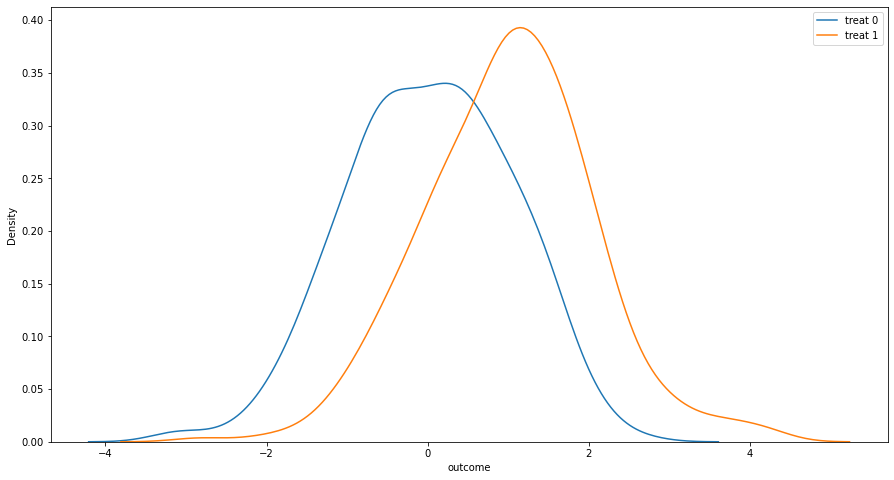

In [44]:
plt.figure(figsize=(15,8))
# Density plots for treatment and control
sns.kdeplot(data=df_e['outcome'][df_e['assignment']==0])
sns.kdeplot(data=df_e['outcome'][df_e['assignment']==1])
plt.legend(labels=["treat 0","treat 1"])

#### Observational study DAG

In [7]:
import cdt
import networkx as nx
cdt.SETTINGS.rpath = '/Library/Frameworks/R.framework/Versions/4.0/Resources/Rscript'

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [62]:
# Skeleton graph
# Skeleton for full dataset
glasso = cdt.independence.graph.Glasso()
skeleton0 = glasso.predict(df_o)

# Skeleton for non-treated
treat0 = df_o[df_o['assignment']==0]
del treat0['assignment']
skeleton1 = glasso.predict(treat0)

# Skeleton for treated
treat1 = df_o[df_o['assignment']==1]
del treat1['assignment']
skeleton2 = glasso.predict(treat1)

KeyError: 'assignment'

GES is ran on the skeleton of the given graph.
PC is ran on the skeleton of the given graph.
PC is ran on the skeleton of the given graph.


AttributeError: 'list' object has no attribute 'is_directed'

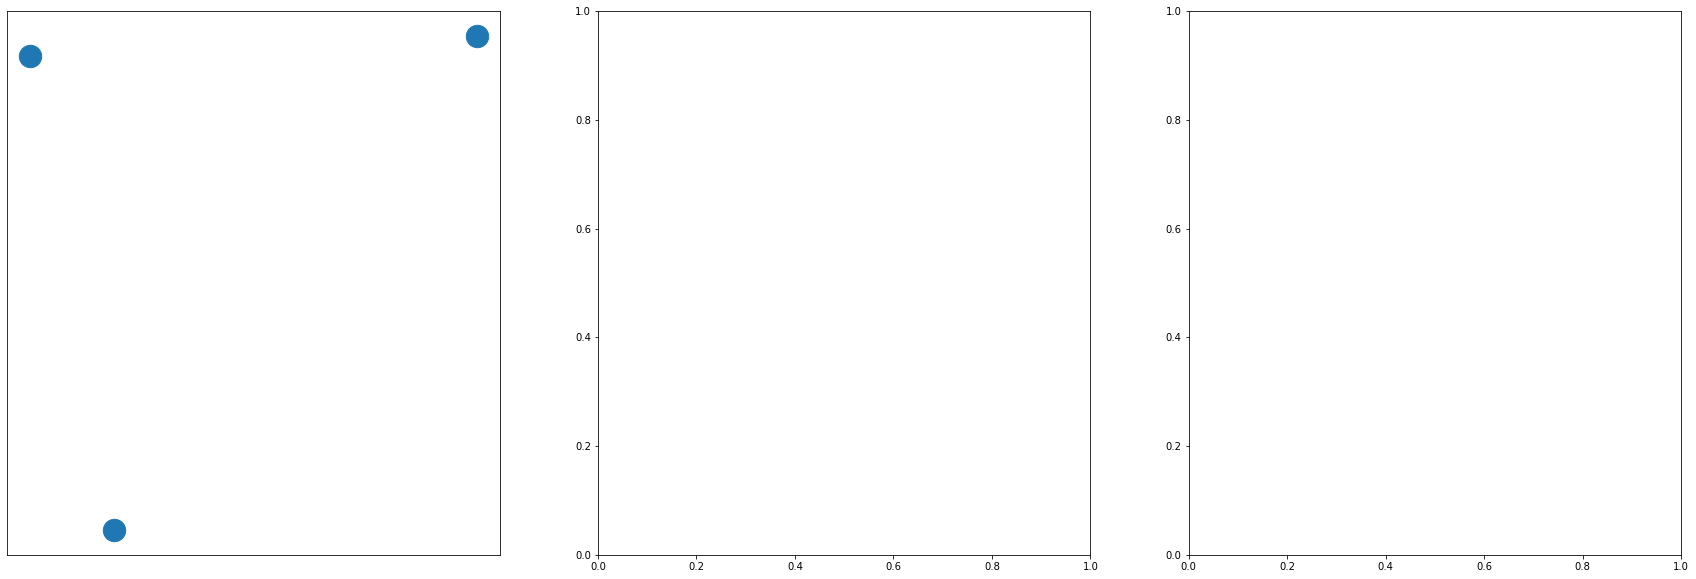

In [54]:
graph_data_1 = df_o
graph_data_2 = treat0
graph_data_3 = treat1

# Full
model_pc0 = cdt.causality.graph.GES()
graph_pc0 = model_pc0.predict(graph_data_1, skeleton0)

# not treated
model_pc1 = cdt.causality.graph.PC()
graph_pc1 = model_pc1.predict(graph_data_2, skeleton1)

# Treat
model_pc2 = cdt.causality.graph.PC()
graph_pc2 = model_pc2.predict(graph_data_3, skeleton2)

#Plot all graphs
graphs = [graph_pc0,graph_pc1,graph_pc2]
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(30, 10))
ax = axes.flatten()
for i in range(3):
    nx.draw_networkx(graphs,font_size=10 ,node_size=500,edge_cmap='Reds',arrowsize=15,edge_color='Green' , ax=ax[i])

plt.show()

PC is ran on the skeleton of the given graph.


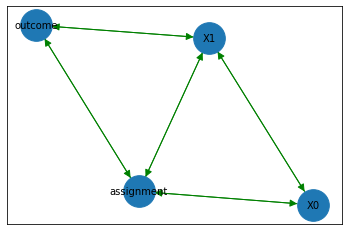

In [73]:

glasso = cdt.independence.graph.Glasso()
skeleton0 = glasso.predict(df_o)
model_pc0 = cdt.causality.graph.PC()
graph_pc0 = model_pc0.predict(df_o, skeleton0)
nx.draw_networkx(graph_pc0,font_size=10 ,node_size=1000,edge_cmap='Reds',arrowsize=15,edge_color='Green')


In [79]:
from causalgraphicalmodels import CausalGraphicalModel

sprinkler = CausalGraphicalModel(
    nodes=["season", "rain", "sprinkler", "wet", "slippery"],
    edges=[
        ("season", "rain"), 
        ("season", "sprinkler"), 
        ("rain", "wet"),
        ("sprinkler", "wet"), 
        ("wet", "slippery")
    ]
)

sprinkler_G = sprinkler.graph


Springer_G = nx.to_numpy_matrix(sprinkler_G)
df_0_matrix = nx.to_numpy_matrix(graph_pc0)

nodes = graph_pc0.nodes
edges = graph_pc0.edges
nodes = list(nodes)
edges = list(edges)
edges.remove( ('X1', 'X0'))


sprinkler = CausalGraphicalModel(nodes=nodes,edges= edges )
#sprinkler.draw()

AssertionError: 

[('X0', 'X1'), ('X1', 'outcome'), ('outcome', 'X1')]

In [71]:
df_0_matrix

matrix([[0., 1., 0.],
        [1., 0., 1.],
        [0., 1., 0.]])

In [51]:
edges

OutEdgeView([('X0', 'X1'), ('X0', 'assignment'), ('X1', 'X0'), ('X1', 'assignment'), ('X1', 'outcome'), ('assignment', 'X0'), ('assignment', 'X1'), ('assignment', 'outcome'), ('outcome', 'X1'), ('outcome', 'assignment')])

In [17]:
# Convert variables to numpy arrays  

outcome_a  = np.array([df_e['outcome']])
assignment_a  = np.array([df_e['assignment']])
X0_a  = np.array([df_e['X0']])
X1_a = np.array(df_e['X1'])
X2_a = np.array(df_e['X2'])
X3_a = np.array(df_e['X3'])
X4_a = np.array(df_e['X4'])
X5_a = np.array(df_e['X5'])
X6_a = np.array(df_e['X6'])

# Reshape arrays 

outcome_a = outcome_a.reshape(722,1)
assignment_a = assignment_a.reshape(722,1)
X0_a = X0_a.reshape(722,1)
X1_a = X1_a.reshape(722,1)
X2_a = X2_a.reshape(722,1)
X3_a = X3_a.reshape(722,1)
X4_a = X4_a.reshape(722,1)
X5_a = X5_a.reshape(722,1)
X6_a = X6_a.reshape(722,1)


## Generate sets for conditional independence testing 

emptyset = [0]*722
emptyset = np.array(emptyset)
emptyset = emptyset.reshape(722,1)

# n-dimensional arrays

z_1 = np.array(df_e[['X0','X1','X2']])

In [13]:
from CCIT import CCIT
from CCIT import DataGen

In [19]:
ci_pvals = []
pvalue = CCIT.CCIT(outcome_a,assignment_a,emptyset) 
ci_pvals.append(pvalue)
ci_pvals

[0.5]